In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

## 1A: Initializing the state space

In [2]:
class State:
    
    def __init__(self, x_position, y_position, heading):
        self.x_position = x_position
        self.y_position = y_position
        self.heading = heading
        
    def return_current_state(self):
        return self.x_position, self.y_position, self.heading

## 1B: Initializing the action space

In [3]:
class Action:
    
    def __init__(self, move, rotation):
        self.move = move
        self.rotation = rotation
        
    def return_action(self):
        return self.move, self.rotation

## 1C: Return the probabilty Psa(s') given pe, s, a, s'
## 1D: return a next state s' given error probability pe, s, a

### This is the Markov decision process

In [34]:
class MarkovDecisionProcess:
    
    # get the length and the width of the space that we are in
    def __init__(self, length, width):
        self.length = length
        self.width = width
    
    # check for bound violations
    def check_bounds(self, next_x, next_y, current_x, current_y):
        if (next_x < 0 or next_x >= self.width):
            next_x = current_x
        if (next_y < 0 or next_y >= self.length):
            next_y = current_y
        return next_x, next_y
    
    #define the directions
    left = {8,9,10}
    right = {2,3,4}
    up = {11,0,1}
    down = {5,6,7}
    
    # find out the next step --> returns next_x, next_y, next_heading
    def next_state_compiled(self, state, action):
        # get x, y and heading from state
        current_x = state.x_position
        current_y = state.y_position
        current_heading = state.heading
        
        # get move and rotation from action
        move = action.move
        rotation = action.rotation
        
        # check if heading is left, need to only change x and not y
        if current_heading in self.left:
            next_x = current_x - move
            next_y = current_y
        
        # check if heading is right, need to only change x and not y
        elif current_heading in self.right:
            next_x = current_x + move
            next_y = current_y
        
        # check if heading is up, need to only change y and not x
        elif current_heading in self.up:
            next_x = current_x
            next_y = current_y + move
        
        # check if heading is down, need to only change y and not x
        else:
            next_x = current_x
            next_y = current_y - move
        
        # need to check the bounds
        next_x, next_y = self.check_bounds(next_x, next_y, current_x, current_y)
        
        # finally, need to accomodate for the rotation in heading
        next_heading = (current_heading + rotation) % 12
        
        return next_x, next_y, next_heading
    
    # find out the next step for the movements that have the prob of error
    def next_state_individualized(self, current_x, current_y, current_heading, move, rotation):
        # check if heading is left, need to only change x and not y
        if current_heading in self.left:
            next_x = current_x - move
            next_y = current_y
        
        # check if heading is right, need to only change x and not y
        elif current_heading in self.right:
            next_x = current_x + move
            next_y = current_y
        
        # check if heading is up, need to only change y and not x
        elif current_heading in self.up:
            next_x = current_x
            next_y = current_y + move
        
        # check if heading is down, need to only change y and not x
        else:
            next_x = current_x
            next_y = current_y - move
        
        # need to check the bounds
        
        next_x, next_y = self.check_bounds(next_x, next_y, current_x, current_y)
        
        # finally, need to accomodate for the rotation in heading
        next_heading = (current_heading + rotation) % 12
        
        return next_x, next_y, next_heading
    
    # find out the transition probabilities
    def transition_probabilities(self, prob_of_error, action, current_state, next_state):
        # get move and rotation from action
        move = action.move
        rotation = action.rotation
        
        # if we do not move, current state should equal next state. 
        if move == 0:
            if current_state.return_current_state() == next_state.return_current_state:
                return 1
            else:
                return 0
        
        # in the case that we do move, need to account for the error probabilities
        
        if next_state.return_current_state() == self.next_state_compiled(current_state, action):
            return 1-(2*prob_of_error)
        else:
            current_x = current_state.x_position
            current_y = current_state.y_position
            current_heading = current_state.heading

            # need to check to return the prob of error
            if next_state.return_current_state() == self.next_state_individualized(current_x, current_y, (current_heading-1)%12, move, rotation):
                return prob_of_error

            if next_state.return_current_state() == self.next_state_individualized(current_x, current_y, (current_heading+1)%12, move, rotation):
                return prob_of_error
        
        return 0
    
    number_of_headings = 12
    
    # Part 1D
    def compute_next_state(self, prob_of_error, current_state, action):
        
        wrong_states = []
        # need to loop through all of the values of x, y and heading
        for i in range(self.length):
            for j in range(self.width):
                for k in range(self.number_of_headings):
                    # define the next state
                    next_state = State(i,j,k)
                    # find the transition probability between current state and the next state
                    prob_of_transition = self.transition_probabilities(prob_of_error, action, current_state, next_state)
                    # if the probability of transitioning does not equal 0, then only do we proceed. If 0, do not care
                    if prob_of_transition != 0:
                        # if our transition probabilty is the probability of error, it means that there was an error. Need to keep track of these next state values
                        if prob_of_transition == prob_of_error:
                            wrong_states.append(next_state)
                        else:
                            correct_next_state = next_state
        # if I choose a random number between 0 and 1 and my number is less than 2*prob_of_error, I move in the wrong direction. If not, I move in the correct direction.
        random_number_generated = np.random.uniform(0,1)
        if random_number_generated < 2*prob_of_error:
            random_index = random.randrange(len(wrong_states))
            return wrong_states[random_index]
        else:
            return correct_next_state

## Test question 1

In [35]:
r = MarkovDecisionProcess(6,6)
s = State(1,1,0)
f = Action(1,0)

print(r.compute_next_state(0.1, s, f).return_current_state())

(1, 2, 0)


## Question 2: Write a function that returns the reward R(s) given input s.

In [36]:
def reward(self, current_state):
    # define the lengh and the width
    length = width = 6
    
    # get the current x, y positions -- do not care about heading
    current_x, current_y, _ = current_state.return_current_state
    
    # define the rewards
    if current_x == 3 and current_y == 4:
        reward = 1
    if current_x == 0 or current_x == width-1:
        reward = -100
    if current_y == 0 or current_y == height-1:
        reward = -100
    if current_x == 2 or current_x == 4:
        if current_y == 2 or current_y == 3 or current_y == 4:
            reward = -1
    return reward

## Question 3a: Create and populate a matrix/array that stores the action a = pi0(s) prescribed by the initial policy pi0 when indexed by state s.

In [44]:
class Policy_Matrix:
    def __init__(self, given_policy=None):
        if given_policy == None:
            up = {11, 0, 1}
            right = {2, 3, 4}
            down = {5, 6, 7}
            left = {8, 9, 10}

            mat_up    = [[None for x in range(6)] for y in range(6)]
            mat_down  = [[None for x in range(6)] for y in range(6)]
            mat_left  = [[None for x in range(6)] for y in range(6)]
            mat_right = [[None for x in range(6)] for y in range(6)]

            rot = 0 # rotation (none-0,left-1,right-2)
            mov = 0 # move (none-0,back-1,forward-2)

            # populate up matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if (x<3): # goal on right
                        rot = 2
                    elif (x>3): # goal on left
                        rot = 1
                    else:
                        rot = 0
                    # determine move
                    if (y<=4):
                        mov = 2
                    else:
                        mov = 1
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_up[x][y] = mov, rot

            # populate down matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if (x<3): # goal on left
                        rot = 1
                    elif (x>3): # goal on right
                        rot = 2
                    else:
                        rot = 0
                    # determine move
                    if (y<=3):
                        mov = 1
                    else:
                        mov = 2
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_down[x][y] = mov, rot

            # populate right matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if(y>4): # goal on right
                        rot = 2
                    elif(y<4): # goal on left
                        rot = 1
                    else:
                        rot = 0
                    # determine move
                    if(x<4):
                        mov = 2
                    else:
                        mov = 1
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_right[x][y] = mov, rot

            # populate left matrix
            for x in range(6):
                for y in range(6):
                    # determine rotation
                    if(y>4): # goal on left
                        rot = 1
                    elif(y<4): # goal on right
                        rot = 2
                    else:
                        rot = 0
                    # determine move
                    if(x<3):
                        mov = 1
                    else:
                        mov = 2
                    # on goal
                    if (x==3 and y==4):
                        rot = 0
                        mov = 0
                    mat_left[x][y] = mov, rot

            # matrix for each heading degree
            self.pol_mat = [[]]*12
            for heading in range(12):
                if heading in up:
                    self.pol_mat[heading] = mat_up
                elif heading in down:
                    self.pol_mat[heading] = mat_down
                elif heading in left:
                    self.pol_mat[heading] = mat_left
                else:
                    self.pol_mat[heading] = mat_right
        else:
            self.pol_mat = given_policy
            
    def policy_action(self, current_state):        
        pos_x = current_state.x_position
        pos_y = current_state.y_position
        heading = current_state.heading
        return self.pol_mat[heading][pos_x][pos_y]

if __name__ == "__main__":
    pi_0 = Policy_Matrix()
#     print(pi_0.pol_mat)

## Question 3b: Write a function to generate and plot a trajectory of a robot given policy matrix/array , initial state s0, and error probability pe.

In [45]:
def compute_trajectory(policy, current_state, prob_of_error):
    # initialize the trajectory
    full_trajectory = []
    # get the current x and y position
    current_x, current_y, _ = current_state.return_current_state()
    # append the current x and y to the trajectory as an array
    full_trajectory.append([current_x, current_y])
    
    # keep looping till we get to the goal
    while current_x != 3 or current_y != 4:
        move_from_policy, rotation_from_policy = Policy_Matrix().policy_action(current_state)
        if move_from_policy == 0:
            move = 0
        if move_from_policy == 1:
            move = -1
        if move_from_policy == 2:
            move = 1
        if rotation_from_policy == 0:
            rotation = 0
        if rotation_from_policy == 1:
            rotation = -1
        if rotation_from_policy == 2:
            rotation = 1
        action = Action(move, rotation)
        next_state = MarkovDecisionProcess(6,6).compute_next_state(prob_of_error, current_state, action)
        current_x, current_y, _ = next_state.return_current_state()
        full_trajectory.append([current_x, current_y])
        print(full_trajectory)
        current_state = next_state
        
    
    # to plot the trajectory, we need to plot out the full trajectory
    for x,y in full_trajectory:
        plt.scatter(x,y,marker="o", color="red")
    plt.show()

## Question 3c:

[[1, 4], [1, 3]]
[[1, 4], [1, 3], [1, 4]]
[[1, 4], [1, 3], [1, 4], [2, 4]]
[[1, 4], [1, 3], [1, 4], [2, 4], [3, 4]]


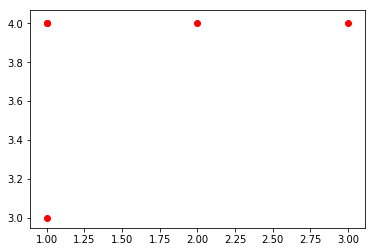

In [46]:
pi_0 = Policy_Matrix()
current_state = State(1,4,6)
compute_trajectory(pi_0, current_state, 0)

## Question 3d: